In [1]:
import os
import sys

script_dir = os.getcwd()
root_dir = f"{script_dir}/../../"
sys.path.append(os.path.join(root_dir, "dpc"))

import numpy as np
import scipy.io
import imageio

import matplotlib.pyplot as plt
%matplotlib inline



import open3d
from open3d import JVisualizer


from util.system import setup_environment
from util.euler import quaternion2euler
from util.image import preprocess_input_image
from render.render_point_cloud import render_point_cloud

#!/usr/bin/env python


import pdb
import time
import torch

from models import model_pc_to as model_pc
from run.ShapeRecords import ShapeRecords
from util.app_config import config as app_config
from util.system import setup_environment
from util.fs import mkdir_if_missing

config.yaml
align_to_canonical = False
batch_size = 8
bicubic_gt_downsampling = False
camera_distance = 2.0
checkpoint_dir = .
clip_gradient_norm = 0.0
compute_validation_loss = True
config = 
decoder_conv_init_stdev = 0.02
decoder_name = pc_decoder
drc_logsum = True
drc_logsum_clip_val = 1e-05
drc_rgb_weight = 0.0
drc_tf_cumulative = True
drc_weight = 0.0
encoder_name = img_encoder
eval_split = val
eval_unsupervised_shape = True
f_dim = 16
fc_dim = 1024
focal_length = 1.875
focal_length_mean = 2.0
focal_length_range = 1.0
focal_range = 0.7
gpu = 0
gpu_allow_growth = False
gt_pc_dir = ../../data/gt/downsampled
image_size = 128
inp_dir = ../../data/tf_records
input_shape = [128, 128, 3]
learn_focal_length = False
learning_rate = 0.0001
learning_rate_2 = 1e-05
learning_rate_step = 1.0
max_dataset_depth = 10.0
max_depth = 10.0
max_number_of_steps = 600000
models_list = 
num_dataset_samples = -1
num_views = 5
num_views_to_use = -1
pc_decoder_init_stddev = 0.025
pc_eval_chamfer_num_parts = 

/home/nbgundav/pc/coolnamehere/experiments/chair_unsupervised/../../dpc/util/config.py:46: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  yaml_cfg = edict(yaml.load(f))


In [2]:
cfg = app_config

setup_environment(cfg)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dir = cfg.checkpoint_dir
mkdir_if_missing(train_dir)

split_name = "test"
dataset_folder = cfg.inp_dir

dataset = ShapeRecords(dataset_folder, cfg,split_name)
dataset_loader = torch.utils.data.DataLoader(dataset,
                                             batch_size=8, shuffle=False,
                                             num_workers=8,drop_last=True)

log_dir = '../../dpc/run/model_run_data/'
model = model_pc.ModelPointCloud(cfg).cuda()
global_step = 100000
if global_step>0:            
    checkpoint_path = os.path.join(log_dir,'model.ckpt_{}.pth'.format(global_step))
    print("Loading from path:",checkpoint_path)
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    global_step_val = checkpoint['global_step']
    model.load_state_dict(checkpoint['model_state_dict'])
else:
    global_step_val = global_step

model = model.to(device)
for i, train_data in enumerate(dataset_loader, 0):
    for k in train_data.keys():
        try:
            train_data[k] = train_data[k].to(device)
        except AttributeError:
            pass
    inputs = model.preprocess(train_data, cfg.step_size)
    outputs = model(inputs, global_step_val, is_training=False, run_projection=True)
    break

Initialized dataset test with size 1355
Loading from path: ../../dpc/run/model_run_data/model.ckpt_100000.pth
Voxel_time 0.10976662486791611


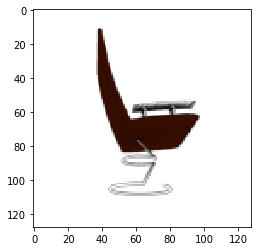

In [4]:
# select an input image from the validation set (splits defined in data/splits)
# the dataset has 5 different viewpoints for the same model
img_idx = 5

input_image_np = inputs['images'].detach().cpu().numpy()[img_idx].transpose(1,2,0)

# show input image
plt.imshow(input_image_np)

In [6]:

camera_pose_np = outputs['poses'].detach().cpu().numpy()[img_idx]

In [7]:
points_np = outputs['all_points'].detach().cpu().numpy().reshape(-1,4,8000,3)[img_idx,2]
# Interactive visualisation with Open3D
pcd = open3d.geometry.PointCloud()
pcd.points = open3d.utility.Vector3dVector(np.squeeze(points_np))

visualizer = open3d.JVisualizer()
visualizer.add_geometry(pcd)
visualizer.show()

JVisualizer with 1 geometries

In [6]:
outputs['poses'].shape

torch.Size([128, 4])

In [36]:
# image 1
all_points = outputs['all_points'][0].usqueeze(0).repeat(128,1,1)
all_rgb = outputs['all_rgb']
camera_pose = outputs['poses'][0]

predicted_translation = outputs["predicted_translation"]

proj_out = pointcloud_project_fast(cfg, all_points, camera_pose, predicted_translation,
                                               all_rgb, _gauss_kernel,
                                               scaling_factor=outputs['all_scaling_factors'],
                                               focal_length=outputs['all_focal_length'])
proj = proj_out["proj"]

RuntimeError: shape '[4, 1]' is invalid for input of size 1

In [31]:
all_points.shape

torch.Size([128, 8000, 3])

In [28]:
projs = torch.squeeze(proj.reshape(32,4,64,64,1)).detach().cpu().numpy()

In [29]:
view_idx_1 = 10
view_idx_2 = 15

In [30]:
proj_1 = projs[view_idx_1]
proj_2 = projs[view_idx_2]


IndexError: index 10 is out of bounds for axis 0 with size 4

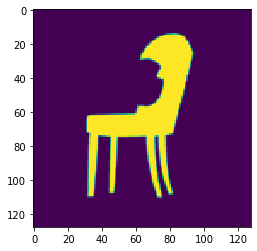

In [25]:
plt.imshow(torch.squeeze(inputs['masks'])[15].cpu().numpy())

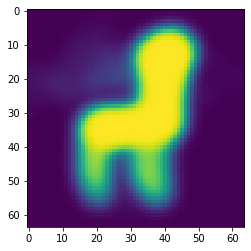

In [26]:
plt.imshow(projs[0])

In [23]:
pc1 = outputs['points_1'].detach().cpu().numpy()[view_idx_1]
pc2 = outputs['points_1'].detach().cpu().numpy()[view_idx_2]

# changing, centre, scale and pose 
scale = 0.5
centre = 0.5*(1-scale) # add or subtract centre

def project_pc_acc_to_config(pc, centre, scale):
    pc_new = pc*scale + centre
    return pc_new
    


In [9]:
pc1_proj = project_pc_acc_to_config(pc1, centre, scale)
pc2_proj = project_pc_acc_to_config(pc2, -centre, scale)


In [5]:

camera_pose_np = outputs['poses'].detach().cpu().numpy()[view_idx]

In [6]:
points_np = outputs['points_1'].detach().cpu().numpy()[3]
# Interactive visualisation with Open3D
pcd = open3d.geometry.PointCloud()
pcd.points = open3d.utility.Vector3dVector(np.squeeze(points_np))

visualizer = open3d.JVisualizer()
visualizer.add_geometry(pcd)
visualizer.show()

JVisualizer with 1 geometries

In [14]:
outputs['points_1'].detach().cpu().numpy().max()

0.44912747